In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import robotdatapy as rdp # 1.0.3
import scipy as sp

# plt.style.use('/home/masonbp/computer/python/matplotlib/publication.mplstyle')
SAVE = True
QUICK = False
ADD_ANNOTATIONS = True

# quicker
if QUICK:
    num_pcs = 100
    num_markers = 500
else:
    num_pcs = 3000
    num_markers = 4000

In [17]:
def get_pc(bag_path, topic, child_frame):
    pcd = rdp.data.PointCloudData.from_bag(
        path=bag_path,
        topic=topic,
        time_tol=100.0,
    )

    marker_data = rdp.data.GeneralData.from_bag(
        path=bag_path,
        topic="/NX01/actual_traj",
        ros_distro='humble',
        time_tol=100.0,
        causal=False
    )

    pc_frame = pcd.msg_header(pcd.t0).frame_id
    print("pc_frame:", pc_frame)

    pd = rdp.data.PoseData.from_bag_tf(
        bag_path,
        parent_frame="map",
        child_frame=child_frame,
        time_tol=100.0
    )

    # Robust point cloud extraction at pcd.tf
    pc = pcd.pointcloud(pcd.tf).get_xyz()
    # if not isinstance(vecs, np.ndarray) or vecs.ndim != 2 or vecs.shape[0] == 0 or vecs.shape[1] != 3:
    #     print(f"[Warning] Empty or invalid point cloud at t = {pcd.tf}. Skipping transform.")
    #     pc = np.zeros((0, 3))
    # else:
    #     pc = rdp.transform.transform(pd.pose(pcd.tf), vecs)

    return pc, pcd, pd, marker_data

def apply_transform(points):
    T_side_view = rdp.transform.xyz_rpy_to_transform([0., 0., 0.], [-85., -0., 0.], degrees=True) @ \
        rdp.transform.xyz_rpy_to_transform([0., 0., 0.,], [0., 0., 80.], degrees=True)
    # T_side_view = np.eye(4)

    # degrees to rotation matrix
    roll = 180
    pitch = 0
    yaw = 0

    rotation_matrix = sp.spatial.transform.Rotation.from_euler('xyz', [roll, pitch, yaw], degrees=True).as_matrix()
    T_world_cam = np.array([
        [1., 0., 0., 60.,],
        [0., -1., 0., 0.,],
        [0., 0., -1., 175.,],
        [0., 0., 0., 1.,]
    ])

    K = np.array([[300, 0., 0.], [0., 300, 0.], [0., 0., 1.]])

    points_cam = rdp.transform.transform(np.linalg.inv(T_world_cam) @ T_side_view, points)
    points_cam = points_cam[points_cam[:,2] > 0.1]
    points_side_view = rdp.camera.xyz_2_pixel(points_cam, K)
    return points_side_view

def plot_pc(pc, pcd, pd, marker_data, bag_path, figure_name):
    import matplotlib.pyplot as plt
    plt.style.use('dark_background')
    t = np.linspace(pcd.t0, pcd.tf, num_pcs)

    pcs = []
    for ti in t:
        vecs = pcd.pointcloud(ti).get_xyz()
        if vecs.ndim != 2 or vecs.shape[0] == 0 or vecs.shape[1] != 3:
            print(f"[Warning] Skipping invalid point cloud at t = {ti}. Shape = {vecs.shape}")
            continue
        pc = vecs
        # pc = rdp.transform.transform(pd.pose(ti), vecs)
        pcs.append(pc)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10), dpi=500)

    if len(pcs) == 0:
        print("[Warning] No valid point clouds found. Skipping point cloud plot.")
        pc = np.zeros((0, 3))  # Fallback
        ax.text(0.5, 0.5, 'No valid point cloud data', transform=ax.transAxes,
                ha='center', va='center', color='white', fontsize=16)
    else:
        pc = np.vstack(pcs)
        ax.plot(pc[:, 0], pc[:, 1], '.', markersize=0.15, alpha=0.2, color='xkcd:white')

        # --- Compute and add a 10 m scale bar ---
        # x_min, x_max = np.min(pc[:, 0]), np.max(pc[:, 0])
        # y_min, y_max = np.min(pc[:, 1]), np.max(pc[:, 1])
        # print("x_min, x_max, y_min, y_max:", x_min, x_max, y_min, y_max)

        # x_pad = 0.05 * (x_max - x_min)
        # y_pad = 0.05 * (y_max - y_min)
        # x_scale_start = x_min + x_pad - 30.0
        # x_scale_end = x_scale_start + 10.0  # 10 meters
        # y_scale = y_max - y_pad + 20.0

        # ax.plot([x_scale_start, x_scale_end], [y_scale, y_scale], color='white', linewidth=1.5)
        # ax.plot([x_scale_start, x_scale_start], [y_scale - 0.5, y_scale + 0.5], color='white', linewidth=0.5)
        # ax.plot([x_scale_end, x_scale_end], [y_scale - 0.5, y_scale + 0.5], color='white', linewidth=0.5)
        # ax.text(x_scale_start, y_scale - 4.5, '10 m', color='white', fontsize=16)

    # --- Plot markers ---
    marker_xyz = []
    marker_colors = []
    for ti in np.linspace(marker_data.t0, marker_data.tf, num_markers):
        position_ros = marker_data.data(ti).pose.position
        color_ros = marker_data.data(ti).color
        mi = np.array([position_ros.x, position_ros.y, position_ros.z])
        marker_xyz.append(rdp.transform.transform(pd.pose(ti), mi))
        marker_colors.append([color_ros.r, color_ros.g, color_ros.b])
    marker_xyz = np.array(marker_xyz)
    marker_colors = np.array(marker_colors)

    for i in range(marker_xyz.shape[0]):
        ax.plot(marker_xyz[i, 0], marker_xyz[i, 1], '.', markersize=1.0, alpha=1.0, color=marker_colors[i])

    # --- Annotations ---
    if ADD_ANNOTATIONS and len(marker_xyz) > 0:
        markersize = 15.0
        bbox_props = dict(facecolor='white', boxstyle='round,pad=0.1')
        ax.plot([marker_xyz[0, 0]], [marker_xyz[0, 1]], '.', markersize=markersize, color='xkcd:red')
        ax.plot([marker_xyz[-1, 0]], [marker_xyz[-1, 1]], '.', markersize=markersize, color='xkcd:blue')
        ax.text(marker_xyz[0, 0] - 10.0, marker_xyz[0, 1] - 1, 'Start', color='red', fontsize=16, bbox=bbox_props)
        ax.text(marker_xyz[-1, 0] + 5.0, marker_xyz[-1, 1] - 1, 'Goal', color='blue', fontsize=16, bbox=bbox_props)

    ax.set_aspect('equal')
    ax.axis('off')

    if SAVE:
        folder_path = bag_path[:bag_path.rfind('/')]
        plt.savefig(folder_path + figure_name, bbox_inches='tight')

    return pc, marker_xyz, marker_colors

def plot_with_angle(pc, marker_xyz, marker_colors, bag_path, figure_name):
    fig, ax = plt.subplots(figsize=(10, 10), dpi=500)

    # Apply side view transform if point cloud is not empty
    if pc.shape[0] > 0:
        pc_side_view = apply_transform(pc)
        ax.plot(pc_side_view[:, 0], -pc_side_view[:, 1], '.', markersize=0.15, alpha=0.2, color='xkcd:white')
    else:
        print("[Warning] No point cloud data for side view. Skipping point cloud plot.")
        ax.text(0.5, 0.5, 'No point cloud', transform=ax.transAxes,
                ha='center', va='center', color='white', fontsize=16)

    # Apply side view transform to marker data if available
    if marker_xyz.shape[0] > 0:
        marker_xyz_side_view = apply_transform(marker_xyz)

        for i in range(marker_xyz_side_view.shape[0]):
            ax.plot(marker_xyz_side_view[i, 0], -marker_xyz_side_view[i, 1], '.',
                    markersize=1.0, alpha=1.0, color=marker_colors[i])

        if ADD_ANNOTATIONS:
            markersize = 10.0
            bbox = dict(facecolor='white', boxstyle='round,pad=0.1')
            # Plot start and goal markers
            ax.plot([marker_xyz_side_view[0, 0]], [-marker_xyz_side_view[0, 1]], '.', markersize=markersize, color='xkcd:red')
            ax.plot([marker_xyz_side_view[-1, 0]], [-marker_xyz_side_view[-1, 1]], '.', markersize=markersize, color='xkcd:blue')
            # Add labels
            ax.text(marker_xyz_side_view[0, 0] - 2, -marker_xyz_side_view[0, 1] + 3,
                    'Start', color='red', fontsize=16, bbox=bbox)
            ax.text(marker_xyz_side_view[-1, 0] - 3, -marker_xyz_side_view[-1, 1] - 5,
                    'Goal', color='blue', fontsize=16, bbox=bbox)
    else:
        print("[Warning] No marker data for side view.")

    ax.set_aspect('equal')
    ax.axis('off')

    if SAVE:
        folder_path = bag_path[:bag_path.rfind('/')]
        plt.savefig(folder_path + figure_name, bbox_inches='tight')


pc_frame: map


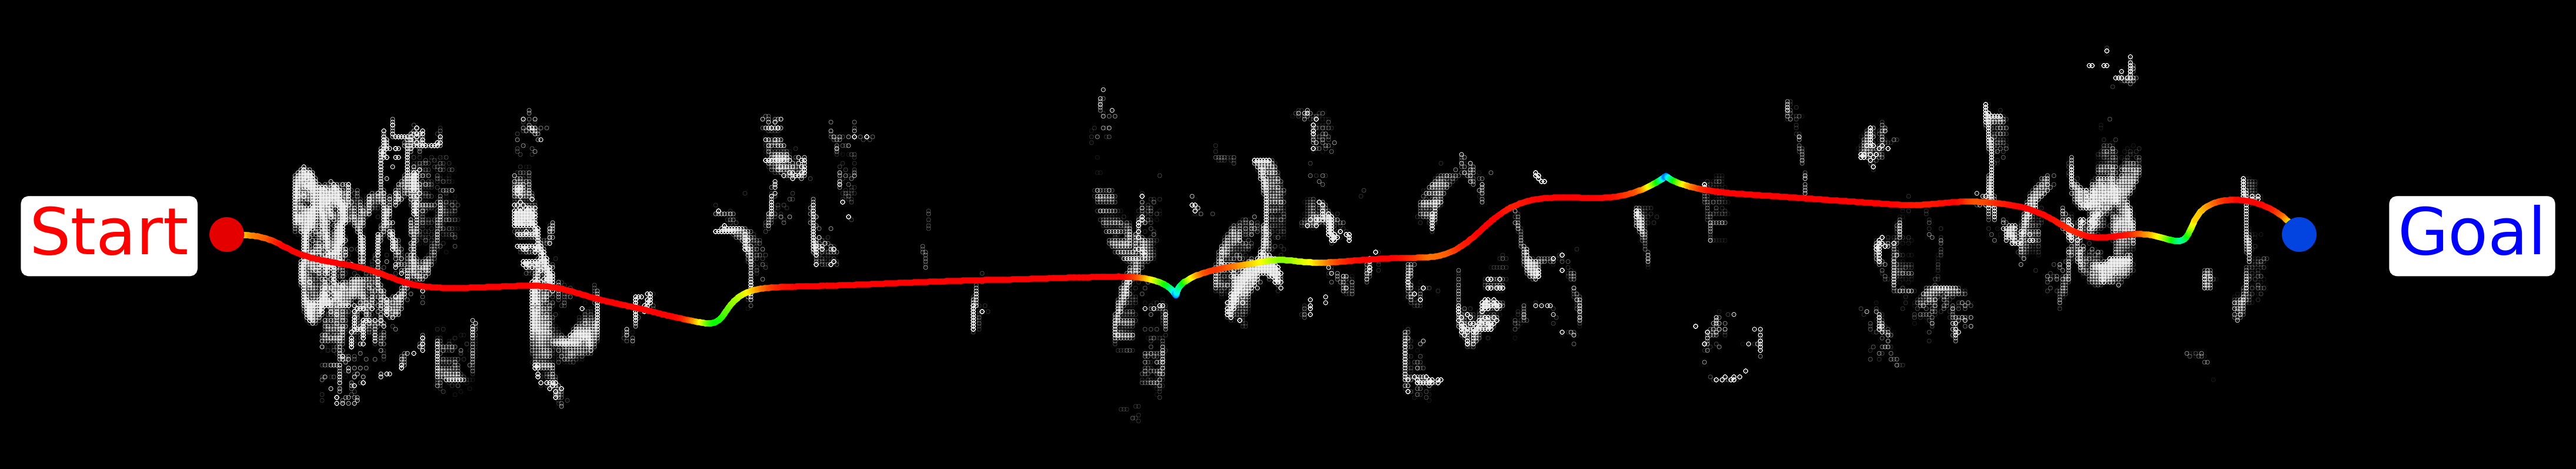

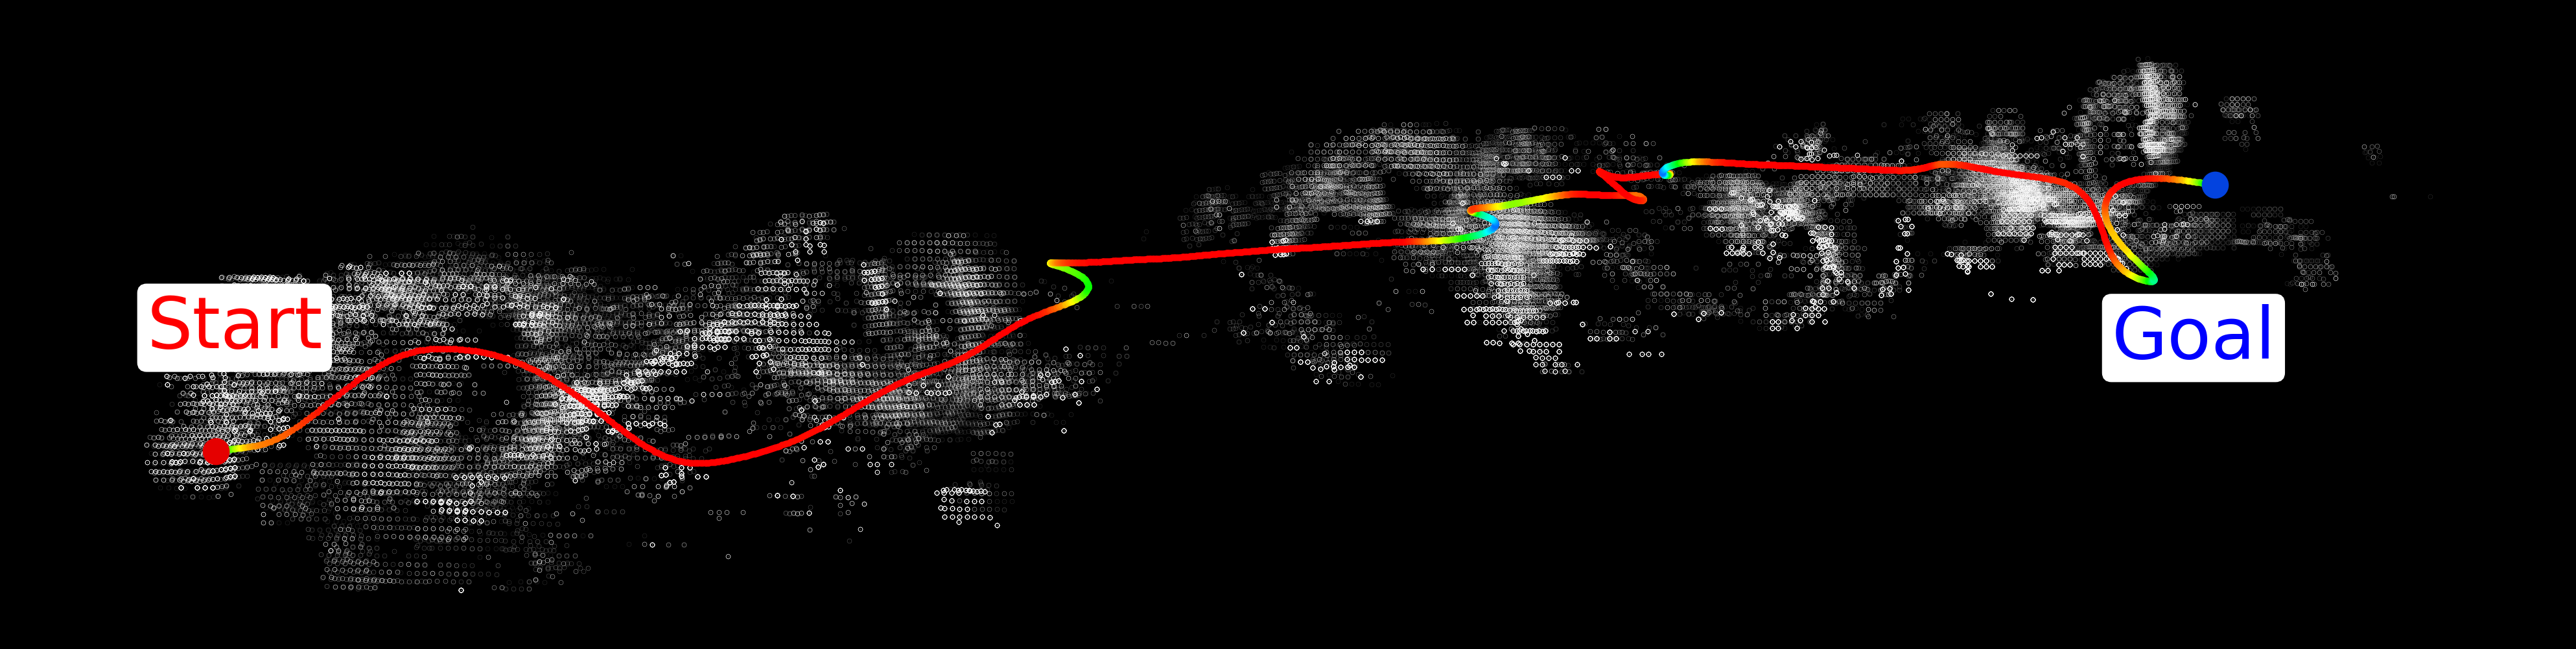

In [ ]:
# plot the point cloud data for dynamic forest test
# topic = "/NX01/mid360_PointCloud2"
topic = "/NX01/occupancy_grid"
bag_num = "1"
dyn_type = "dyn_obst_only" # "dynamic_forest"

bag_path = f"/media/kkondo/kota_elements/mighty/dynamic_obstacle/{dyn_type}/bags/mighty/num_{bag_num}/num_{bag_num}"
pc, pcd, pd, marker_data = get_pc(bag_path, topic, child_frame="NX01/NX01_livox")

paper_path = f"/home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/{dyn_type}"
pc, marker_xyz, marker_colors = plot_pc(pc, pcd, pd, marker_data, paper_path, f"/dynamic_{bag_num}_overhead_pc.png")
plot_with_angle(pc, marker_xyz, marker_colors, paper_path, f"/dynamic_{bag_num}_side_view_pc.png")

pc_frame: map
pc_frame: map
pc_frame: map
pc_frame: map
pc_frame: map
pc_frame: map
pc_frame: map
pc_frame: map
pc_frame: map
pc_frame: map


/tmp/ipykernel_1709151/2175571759.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", max(1, len(trajs)))


[OK] Saved: /home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dyn_obst_only/dynamic_overhead_trajectories_0-9.png


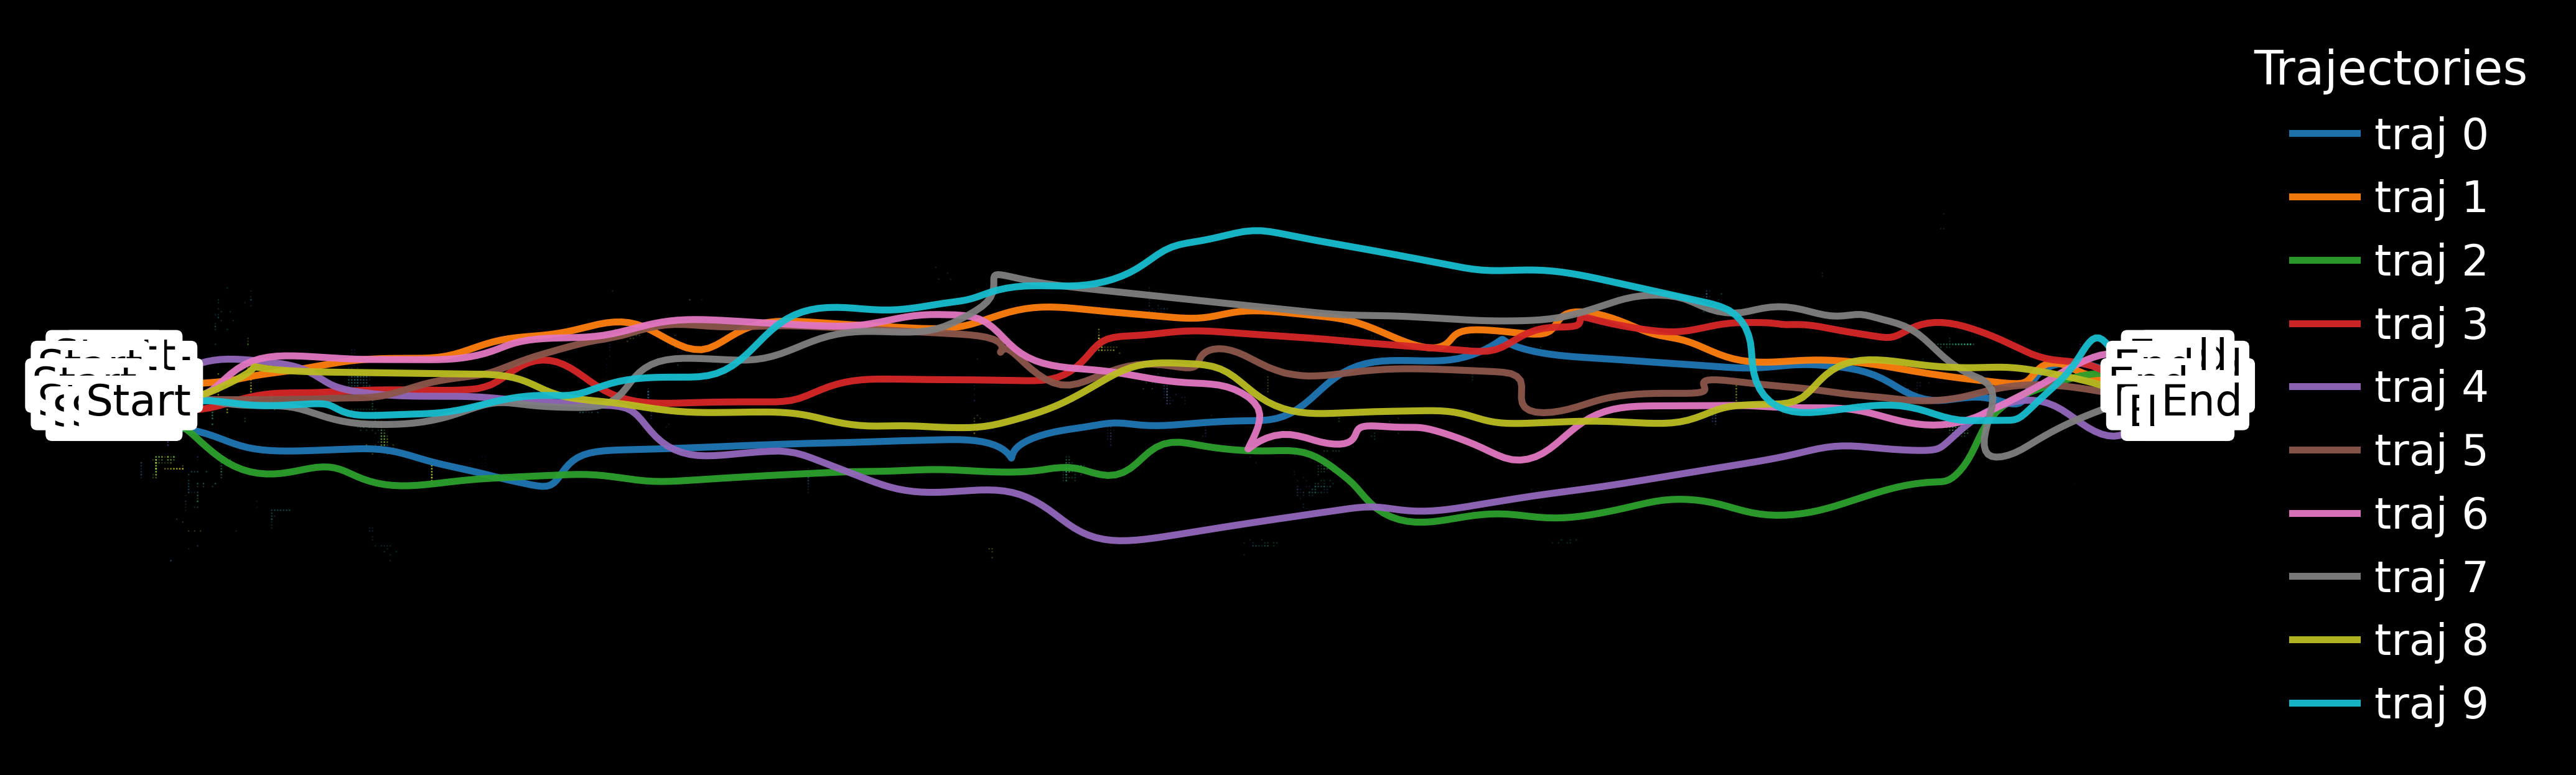

In [ ]:
# ==== Overlay 10 trajectories (bags 0..9) with colored PC, Start/End labels, right-side legend ====
# CONFIG — tweak as needed
dyn_type            = "dyn_obst_only"      # e.g., "dyn_obst_only" or "dynamic_forest"
algo_dir            = "mighty"             # algorithm subfolder under bags/
topic               = "/NX01/occupancy_grid"
child_frame         = "NX01/NX01_livox"
bag_indices         = list(range(10))      # 0..9
num_markers         = 50                  # samples per trajectory
num_pcs_bg          = 500                   # PC frames from bag 0 for background
DRAW_PC_FROM_BAG0   = True
COLOR_PC_BY_Z       = True                 # color point cloud by height (z)
SAVE                = True
out_dir             = f"/home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/{dyn_type}"
out_name            = "dynamic_overhead_trajectories_0-9.png"

# Style + imports
import os, numpy as np, matplotlib.pyplot as plt
plt.style.use("dark_background")

# ---------- helpers ----------
def _extract_traj_xyz(marker_data, pd, n_samples):
    t_grid = np.linspace(marker_data.t0, marker_data.tf, n_samples)
    pts = []
    for ti in t_grid:
        pos = marker_data.data(ti).pose.position
        mi = np.array([pos.x, pos.y, pos.z])
        pts.append(rdp.transform.transform(pd.pose(ti), mi))
    return np.vstack(pts)

def _get_pc_xyz_for_bg(pcd, n_frames):
    t_grid = np.linspace(pcd.t0, pcd.tf, n_frames)
    pcs = []
    for ti in t_grid:
        vecs = pcd.pointcloud(ti).get_xyz()
        if isinstance(vecs, np.ndarray) and vecs.ndim == 2 and vecs.shape[1] == 3 and vecs.shape[0] > 0:
            pcs.append(vecs)
    return np.vstack(pcs) if pcs else np.zeros((0, 3))

# ---------- gather data ----------
bag_root = f"/media/kkondo/kota_elements/mighty/dynamic_obstacle/{dyn_type}/bags/{algo_dir}"
trajs = []          # list of (bag_index, (N,3) array)
failed = []

pc_bg = np.zeros((0, 3))
pc_bg_bounds = None

for i in bag_indices:
    bag_path = f"{bag_root}/num_{i}/num_{i}"
    try:
        pc, pcd, pd, marker_data = get_pc(bag_path, topic, child_frame)

        # background PC (from first bag only, to keep it light)
        if DRAW_PC_FROM_BAG0 and i == bag_indices[0]:
            pc_bg = _get_pc_xyz_for_bg(pcd, num_pcs_bg)
            if pc_bg.size > 0:
                xmin, xmax = np.min(pc_bg[:,0]), np.max(pc_bg[:,0])
                ymin, ymax = np.min(pc_bg[:,1]), np.max(pc_bg[:,1])
                dx, dy = xmax - xmin, ymax - ymin
                pc_bg_bounds = (xmin - 0.05*dx, xmax + 0.05*dx, ymin - 0.05*dy, ymax + 0.05*dy)

        # trajectory in map frame
        traj_xyz = _extract_traj_xyz(marker_data, pd, num_markers)
        trajs.append((i, traj_xyz))
    except Exception as e:
        print(f"[Warn] Skipping bag {i} at {bag_path}: {e}")
        failed.append(i)

# ---------- plot ----------
fig, ax = plt.subplots(figsize=(10, 10), dpi=500)

# Background PC — colored by height (z)
if pc_bg.size > 0:
    if COLOR_PC_BY_Z:
        z = pc_bg[:, 2]
        # normalize z for color mapping
        z_min, z_max = np.percentile(z, 1), np.percentile(z, 99)
        z = np.clip((z - z_min) / max(1e-6, (z_max - z_min)), 0.0, 1.0)
        ax.scatter(pc_bg[:, 0], pc_bg[:, 1], s=0.15, c=z, cmap="viridis", alpha=0.4, linewidths=0)
    else:
        ax.plot(pc_bg[:, 0], pc_bg[:, 1], ".", markersize=0.15, alpha=0.15)

# distinct colors for up to 10 trajectories
cmap = plt.cm.get_cmap("tab10", max(1, len(trajs)))

# small offset (meters) so labels don't stack perfectly
offset_base = 1.5

for k, (i, traj) in enumerate(trajs):
    color_k = cmap(k)
    # main polyline
    ax.plot(traj[:, 0], traj[:, 1], linewidth=1.6, alpha=0.95, label=f"traj {i}", color=color_k)
    # start/end markers
    ax.plot(traj[0, 0],  traj[0, 1],  ".", ms=8, color=color_k, alpha=0.95)          # start dot
    ax.plot(traj[-1, 0], traj[-1, 1], "o", ms=5, fillstyle="none", color=color_k, alpha=0.95)  # end circle

    # text labels "Start" and "End"
    theta = (k / max(1, len(trajs))) * 2 * np.pi
    dx, dy = offset_base * np.cos(theta), offset_base * np.sin(theta)
    bbox = dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.15")
    ax.text(traj[0, 0] + dx,  traj[0, 1] + dy,  "Start", color="black", fontsize=10, bbox=bbox)
    ax.text(traj[-1, 0] + dx, traj[-1, 1] + dy, "End",   color="black", fontsize=10, bbox=bbox)

ax.set_aspect("equal")
ax.axis("off")

# Keep axes around background if available
if pc_bg_bounds is not None:
    ax.set_xlim(pc_bg_bounds[0], pc_bg_bounds[1])
    ax.set_ylim(pc_bg_bounds[2], pc_bg_bounds[3])

# Move legend to the right side (outside the axes)
fig.subplots_adjust(right=0.82)  # leave room on the right
leg = ax.legend(
    title="Trajectories",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=10,
    handlelength=1.5,
    handletextpad=0.4,
    borderaxespad=0.0,
    ncol=1
)
if leg is not None and leg.get_title() is not None:
    leg.get_title().set_fontsize(11)

# Save
if SAVE:
    os.makedirs(out_dir, exist_ok=True)
    save_path = os.path.join(out_dir, out_name)
    plt.savefig(save_path, bbox_inches="tight", pad_inches=0.05)
    print(f"[OK] Saved: {save_path}")

plt.show()


Video FPS: 15.00, Total Frames: 413, Duration: 27.53s
Chunk 1: 0.00s to 8.00s, Frames used: 120
Saved composite image to /home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dyn_obst_only/chunk_1.jpg
Chunk 2: 8.00s to 16.00s, Frames used: 120
Saved composite image to /home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dyn_obst_only/chunk_2.jpg
Chunk 3: 16.00s to 24.00s, Frames used: 120
Saved composite image to /home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dyn_obst_only/chunk_3.jpg
First frame saved to: /home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dyn_obst_only/first_frame.jpg


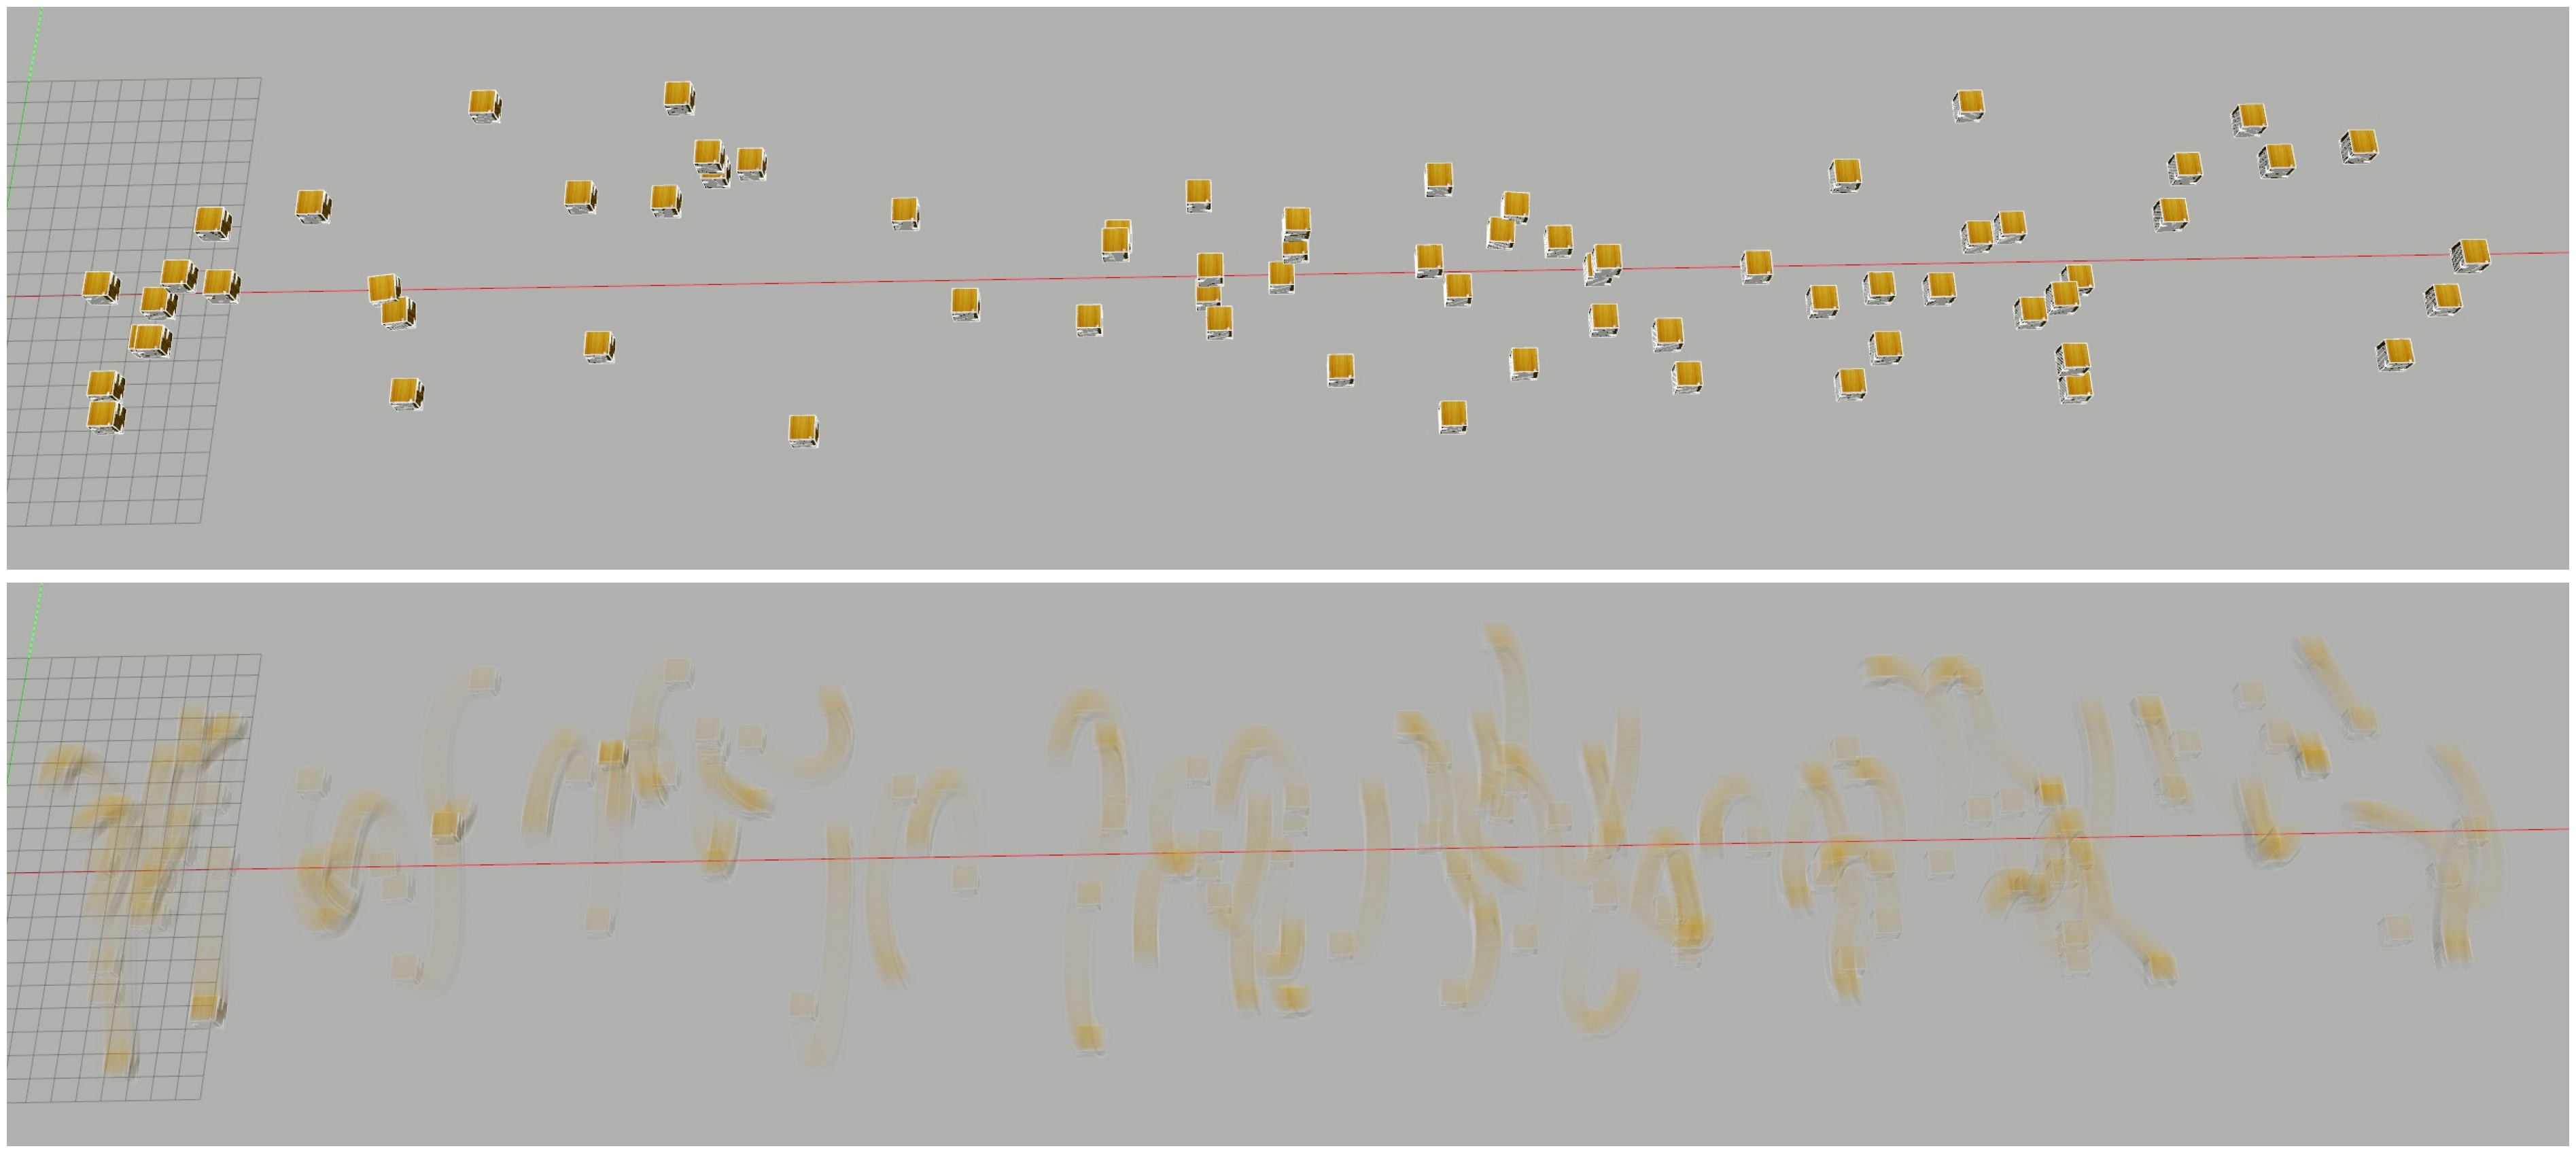

In [58]:
import cv2
import numpy as np
import os

# -------------------------
# User-defined parameters
# -------------------------
video_path = "/media/kkondo/kota_elements/mighty/dynamic_obstacle/dyn_obst_only/only_dynamic_obst_gazebo.mp4"
output_folder = "/home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dyn_obst_only"
alpha = 0.02  # Blending factor
chunk_duration_sec = 8.0  # Length of time per composite in seconds

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# -------------------------
# Open the video file
# -------------------------
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError(f"Cannot open video file: {video_path}")

# Retrieve video properties
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration_sec = total_frames / fps
print(f"Video FPS: {fps:.2f}, Total Frames: {total_frames}, Duration: {duration_sec:.2f}s")

# Frames per 8-second chunk
chunk_frames = int(chunk_duration_sec * fps)

def create_composite_iterative(start_frame, end_frame, alpha):
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    composite = None
    frame_count = 0

    for frame_idx in range(start_frame, end_frame):
        ret, frame = cap.read()
        if not ret:
            break
        frame = frame.astype(np.float32)
        if composite is None:
            composite = frame
        else:
            composite = composite * (1 - alpha) + frame * alpha
        frame_count += 1

    if composite is not None:
        composite = np.clip(composite, 0, 255).astype(np.uint8)
    return composite, frame_count

# Process all full-length 8-second chunks
chunk_index = 0
for start in range(0, total_frames - chunk_frames + 1, chunk_frames):
    end = start + chunk_frames
    composite_img, count = create_composite_iterative(start, end, alpha)

    start_time = start / fps
    end_time = end / fps
    print(f"Chunk {chunk_index + 1}: {start_time:.2f}s to {end_time:.2f}s, Frames used: {count}")

    if composite_img is not None:
        annotation_text = f"{start_time:.2f}s - {end_time:.2f}s"
        cv2.putText(composite_img, annotation_text, (30, composite_img.shape[0] - 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 4, cv2.LINE_AA)
        output_filename = os.path.join(output_folder, f"chunk_{chunk_index + 1}.jpg")
        cv2.imwrite(output_filename, composite_img)
        print(f"Saved composite image to {output_filename}")

    chunk_index += 1

cap.release()

import cv2
import os

# -------------------------
# User-defined parameters
# -------------------------
output_filename = "first_frame.jpg"                                           # Output image filename

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Open the video file
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError(f"Cannot open video file: {video_path}")

# Read the first frame
ret, frame = cap.read()
if not ret:
    raise RuntimeError("Failed to read the first frame of the video.")

# Save the first frame
save_path = os.path.join(output_folder, output_filename)
cv2.imwrite(save_path, frame)
print(f"First frame saved to: {save_path}")

# Release the video capture object
cap.release()

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Load images
gazebo_image = plt.imread(output_folder + '/first_frame.jpg')
transparent_image = plt.imread(output_folder + '/chunk_1.jpg')

# Create a figure with GridSpec layout and white background
fig_size_x = 38
fig_size_y = fig_size_x * 0.45
fig = plt.figure(figsize=(fig_size_x, fig_size_y), facecolor='white')  # <- background white
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

# Crop the images
gazebo_image = gazebo_image[400:gazebo_image.shape[0]-400, 550:gazebo_image.shape[1]-200]
transparent_image = transparent_image[400:transparent_image.shape[0]-400, 550:transparent_image.shape[1]-200]

# Just plot cropped image
ax_gazebo = fig.add_subplot(gs[0, 0])
ax_gazebo.imshow(gazebo_image)
ax_gazebo.axis('off')
ax_gazebo.set_facecolor('white')  # <- white background for subplot

# Transparent overlay image
ax_transparent = fig.add_subplot(gs[1, 0])
ax_transparent.imshow(transparent_image)
ax_transparent.axis('off')
ax_transparent.set_facecolor('white')  # <- white background for subplot

plt.tight_layout()

# Save the figure with white background
# plt.savefig("/media/kkondo/T7/unc/dynamic_forest/images/dynamic_env_gazebo.png", bbox_inches='tight', facecolor='white')
plt.savefig("/home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dyn_obst_only/dynamic_env_gazebo.png", bbox_inches='tight', facecolor='white')

Video FPS: 15.00, Total Frames: 497, Duration: 33.13s
Chunk 1: 0.00s to 8.00s, Frames used: 120
Saved composite image to /home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dynamic_forest/chunk_1.jpg
Chunk 2: 8.00s to 16.00s, Frames used: 120
Saved composite image to /home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dynamic_forest/chunk_2.jpg
Chunk 3: 16.00s to 24.00s, Frames used: 120
Saved composite image to /home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dynamic_forest/chunk_3.jpg
Chunk 4: 24.00s to 32.00s, Frames used: 120
Saved composite image to /home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dynamic_forest/chunk_4.jpg
First frame saved to: /home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dynamic_forest/first_frame.jpg


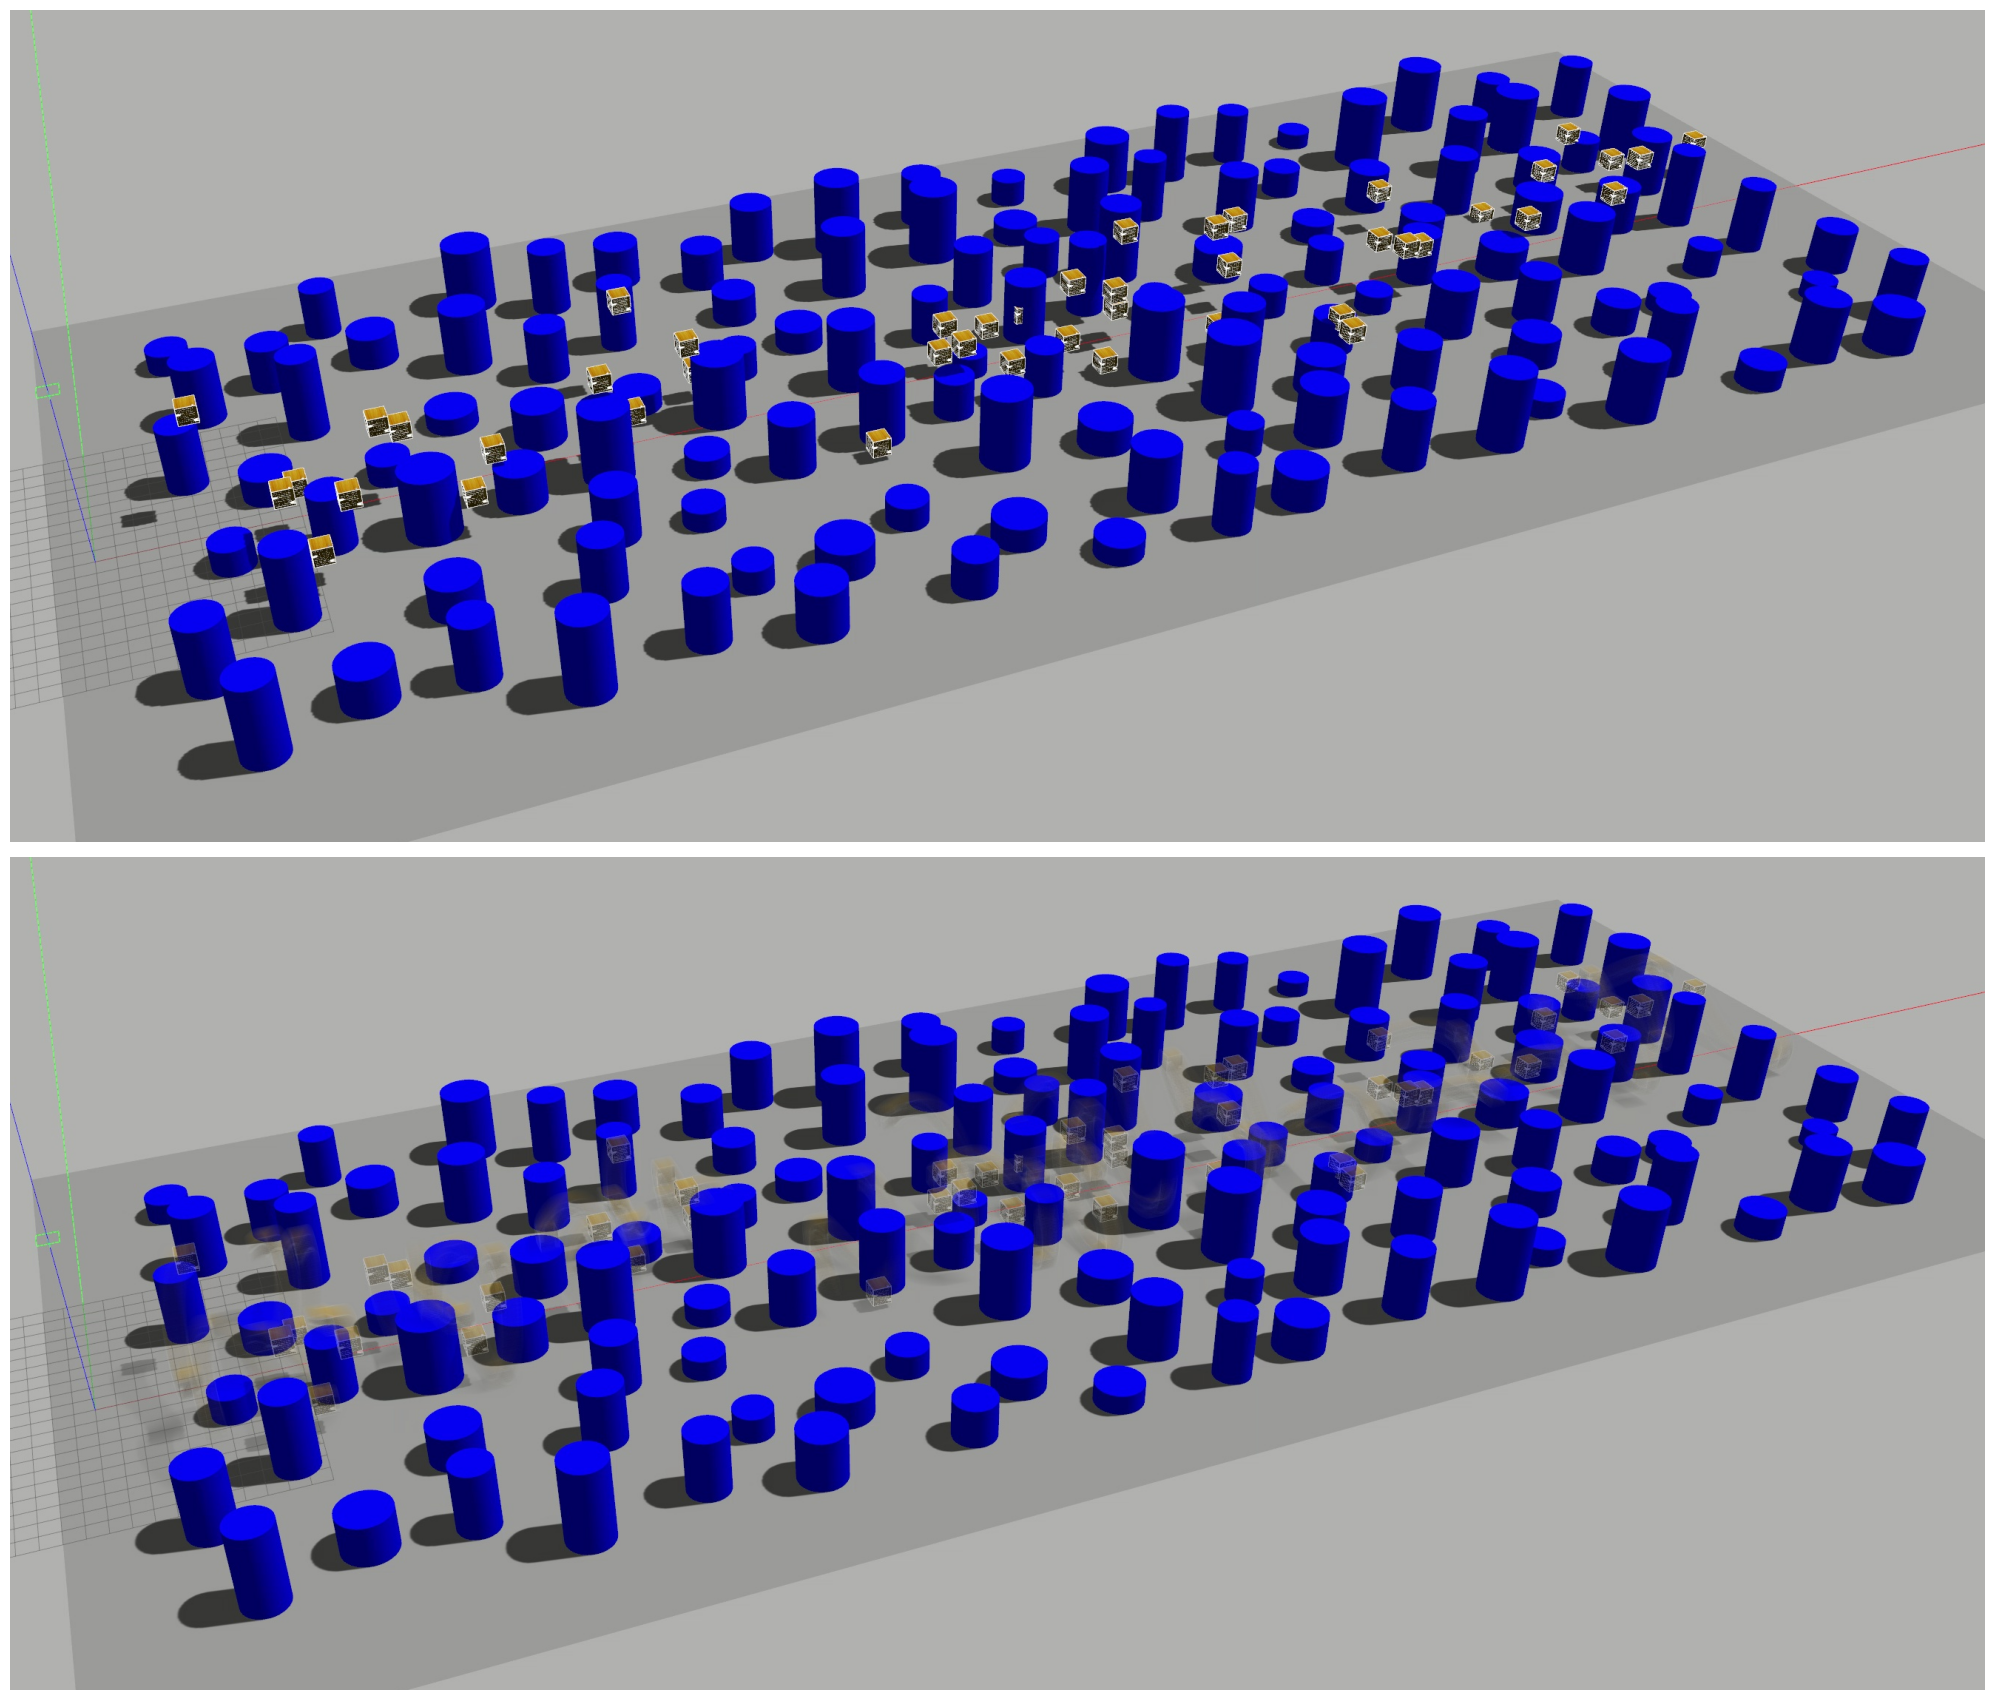

In [57]:
import cv2
import os

import cv2
import numpy as np
import os

# -------------------------
# User-defined parameters
# -------------------------
video_path = "/media/kkondo/kota_elements/mighty/dynamic_obstacle/dynamic_forest/dynamic_forest_gazebo.mp4"
output_folder = "/home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dynamic_forest/"
alpha = 0.01  # Blending factor
chunk_duration_sec = 8.0  # Length of time per composite in seconds

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# -------------------------
# Open the video file
# -------------------------
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError(f"Cannot open video file: {video_path}")

# Retrieve video properties
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration_sec = total_frames / fps
print(f"Video FPS: {fps:.2f}, Total Frames: {total_frames}, Duration: {duration_sec:.2f}s")

# Frames per 8-second chunk
chunk_frames = int(chunk_duration_sec * fps)

def create_composite_iterative(start_frame, end_frame, alpha):
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    composite = None
    frame_count = 0

    for frame_idx in range(start_frame, end_frame):
        ret, frame = cap.read()
        if not ret:
            break
        frame = frame.astype(np.float32)
        if composite is None:
            composite = frame
        else:
            composite = composite * (1 - alpha) + frame * alpha
        frame_count += 1

    if composite is not None:
        composite = np.clip(composite, 0, 255).astype(np.uint8)
    return composite, frame_count

# Process all full-length 8-second chunks
chunk_index = 0
for start in range(0, total_frames - chunk_frames + 1, chunk_frames):
    end = start + chunk_frames
    composite_img, count = create_composite_iterative(start, end, alpha)

    start_time = start / fps
    end_time = end / fps
    print(f"Chunk {chunk_index + 1}: {start_time:.2f}s to {end_time:.2f}s, Frames used: {count}")

    if composite_img is not None:
        annotation_text = f"{start_time:.2f}s - {end_time:.2f}s"
        cv2.putText(composite_img, annotation_text, (30, composite_img.shape[0] - 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 4, cv2.LINE_AA)
        output_filename = os.path.join(output_folder, f"chunk_{chunk_index + 1}.jpg")
        cv2.imwrite(output_filename, composite_img)
        print(f"Saved composite image to {output_filename}")

    chunk_index += 1

cap.release()

# -------------------------
# User-defined parameters
# -------------------------
output_filename = "first_frame.jpg"                                           # Output image filename

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Open the video file
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError(f"Cannot open video file: {video_path}")

# Read the first frame
ret, frame = cap.read()
if not ret:
    raise RuntimeError("Failed to read the first frame of the video.")

# Save the first frame
save_path = os.path.join(output_folder, output_filename)
cv2.imwrite(save_path, frame)
print(f"First frame saved to: {save_path}")

# Release the video capture object
cap.release()

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Load images
gazebo_image = plt.imread(output_folder + '/first_frame.jpg')
transparent_image = plt.imread(output_folder + '/chunk_1.jpg')

# Create a figure with GridSpec layout and white background
fig_size_x = 38
fig_size_y = fig_size_x * 0.45
fig = plt.figure(figsize=(fig_size_x, fig_size_y), facecolor='white')  # <- background white
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

# Crop the images
gazebo_image = gazebo_image[150:gazebo_image.shape[0]-100, 600:gazebo_image.shape[1]-100]
transparent_image = transparent_image[150:transparent_image.shape[0]-100, 600:transparent_image.shape[1]-100]

# Just plot cropped image
ax_gazebo = fig.add_subplot(gs[0, 0])
ax_gazebo.imshow(gazebo_image)
ax_gazebo.axis('off')
ax_gazebo.set_facecolor('white')  # <- white background for subplot

# Transparent overlay image
ax_transparent = fig.add_subplot(gs[1, 0])
ax_transparent.imshow(transparent_image)
ax_transparent.axis('off')
ax_transparent.set_facecolor('white')  # <- white background for subplot

plt.tight_layout()

# Save the figure with white background
# plt.savefig("/media/kkondo/T7/unc/dynamic_forest/images/dynamic_env_gazebo.png", bbox_inches='tight', facecolor='white')
plt.savefig("/home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dynamic_forest/dynamic_env_gazebo.png", bbox_inches='tight', facecolor='white')



In [73]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle

def compose_inset(
    side_path,
    top_path,
    save_path=None,
    *,
    # --- NEW: optional header image (stacked above the composed one)
    header_path=None,
    header_crop=dict(top=0, bottom=0, left=0, right=0),
    header_alpha=1.0,
    # --- Cropping: ints in pixels (trim from each edge)
    side_crop=dict(top=0, bottom=0, left=0, right=0),
    top_crop=dict(top=0, bottom=0, left=0, right=0),
    # --- Inset placement & style
    inset_w_frac=0.35,         # inset width as fraction of parent axis (0..1)
    inset_pad_frac=0.02,       # padding from edges inside parent axis (0..~0.2)
    inset_loc='lower right',   # 'lower/upper right/left'
    inset_alpha=1.0,           # transparency of inset image (0..1)
    # --- Border (white line) around inset
    draw_border=True,
    border_color='white',
    border_width=3.0,          # points
    border_inner_pad=0.005,    # gap between inset image and border (0..~0.05)
    # --- Figure & export
    fig_width_in=12.0,         # overall figure width (inches)
    dpi_save=300,
    facecolor='white',
    # spacing between header and bottom section (if header_path provided)
    hspace=0.02,
    show=True
):
    """
    If header_path is provided, creates a 2-row figure:
      Row 1: header image (cropped)
      Row 2: side image with a bottom-right inset (top image), aspect-preserving.
    Otherwise, just the composed bottom row is produced.

    Returns (fig, ax_main, in_ax, ax_header_or_None).
    """

    def _as_crop_dict(c):
        if isinstance(c, dict):
            return {k: int(max(0, c.get(k, 0))) for k in ('top','bottom','left','right')}
        if isinstance(c, (tuple, list)) and len(c) == 4:
            t,b,l,r = c
            return dict(top=int(max(0,t)), bottom=int(max(0,b)),
                        left=int(max(0,l)), right=int(max(0,r)))
        return dict(top=0, bottom=0, left=0, right=0)

    def _crop(img, cdict):
        h, w = img.shape[:2]
        t, b, l, r = cdict['top'], cdict['bottom'], cdict['left'], cdict['right']
        t = min(t, h-1); b = min(b, h-1); l = min(l, w-1); r = min(r, w-1)
        btm = h - b if b > 0 else h
        rgt = w - r if r > 0 else w
        return img[t:btm, l:rgt]

    # --- Load & crop main images
    side_img = plt.imread(side_path)
    top_img  = plt.imread(top_path)
    side_crop = _as_crop_dict(side_crop)
    top_crop  = _as_crop_dict(top_crop)
    side_img = _crop(side_img, side_crop)
    top_img  = _crop(top_img,  top_crop)

    # --- Optional header
    header_img = None
    if header_path is not None:
        header_img = plt.imread(header_path)
        header_crop = _as_crop_dict(header_crop)
        header_img = _crop(header_img, header_crop)

    # --- Compute section heights to preserve aspect (given width)
    h_side,  w_side  = side_img.shape[:2]
    h_topi,  w_topi  = top_img.shape[:2]
    main_height_in   = fig_width_in * (h_side / w_side)
    header_height_in = fig_width_in * (header_img.shape[0] / header_img.shape[1]) if header_img is not None else 0.0
    total_height_in  = main_height_in + header_height_in

    # --- Build figure (1 or 2 rows)
    if header_img is None:
        fig = plt.figure(figsize=(fig_width_in, main_height_in), facecolor=facecolor)
        ax_main = fig.add_subplot(111)
        ax_header = None
    else:
        fig = plt.figure(figsize=(fig_width_in, total_height_in), facecolor=facecolor)
        gs = fig.add_gridspec(
            2, 1,
            height_ratios=[header_height_in, main_height_in],
            hspace=hspace
        )
        ax_header = fig.add_subplot(gs[0, 0])
        ax_main   = fig.add_subplot(gs[1, 0])

        # Header axis
        ax_header.imshow(header_img, alpha=header_alpha)
        ax_header.axis('off')
        ax_header.set_facecolor(facecolor)

    # --- Main axis (side image)
    ax_main.imshow(side_img)
    ax_main.axis('off')
    ax_main.set_facecolor(facecolor)

    # --- Inset size preserving top image aspect
    parent_ar = h_side / w_side
    top_ar    = h_topi / w_topi
    inset_h_frac = inset_w_frac * (top_ar / parent_ar)
    inset_w_frac = min(max(0.0, inset_w_frac), 0.98)
    inset_h_frac = min(max(0.0, inset_h_frac), 0.98)

    # Keep inset away from edges via a padded bbox
    pad = max(0.0, min(inset_pad_frac, 0.2))
    bbox = (pad, pad, 1 - 2*pad, 1 - 2*pad)  # (x0, y0, w, h) in axes fraction

    in_ax = inset_axes(
        ax_main,
        width=f"{inset_w_frac*100:.2f}%",
        height=f"{inset_h_frac*100:.2f}%",
        loc=inset_loc,
        bbox_to_anchor=bbox,
        bbox_transform=ax_main.transAxes,
        borderpad=0.0
    )

    in_ax.imshow(top_img, alpha=inset_alpha)
    in_ax.axis('off')

    # Optional white border as a rectangle patch
    if draw_border:
        inner_pad = max(0.0, min(border_inner_pad, 0.1))
        in_ax.add_patch(
            Rectangle(
                (inner_pad, inner_pad),
                1 - 2*inner_pad, 1 - 2*inner_pad,
                transform=in_ax.transAxes,
                fill=False,
                linewidth=border_width,
                edgecolor=border_color,
                zorder=10
            )
        )

    plt.tight_layout(pad=0.02)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', facecolor=facecolor, dpi=dpi_save)
        print(f"Saved to: {save_path}")
    if show:
        plt.show()

    return fig, ax_main, in_ax, ax_header


/tmp/ipykernel_1709151/2809573753.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.02)


Saved to: /home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dyn_obst_only/dyn_obst_results_with_env.png


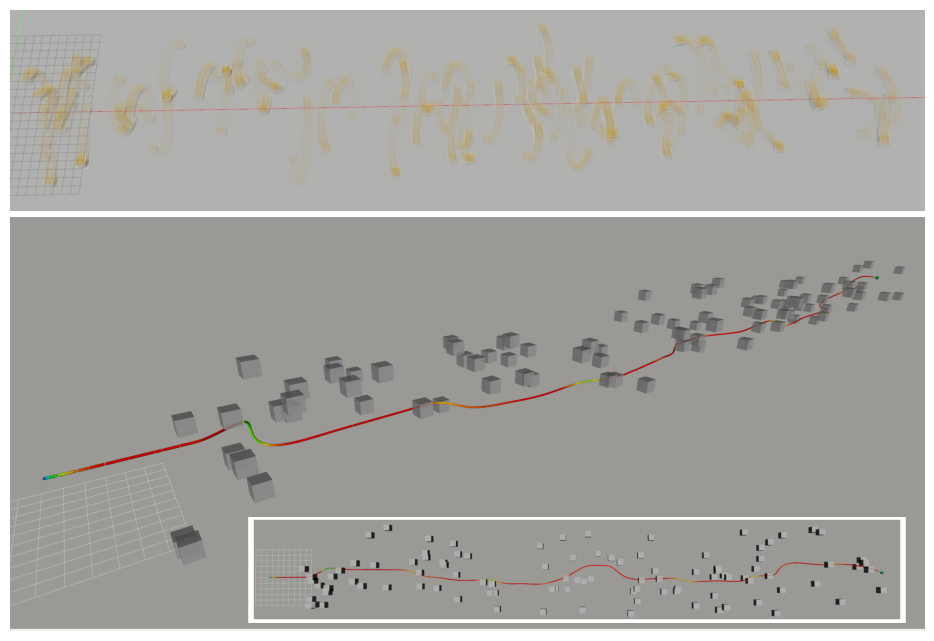

(<Figure size 1200x806.852 with 3 Axes>, <Axes: >, <AxesHostAxes: >, <Axes: >)

In [76]:
import os

# Paths
paper_folder  = "/home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dyn_obst_only"

side_path  = os.path.join(paper_folder, "dyn_obst_only_side_rviz_num_8.png")    # background
top_path   = os.path.join(paper_folder, "dyn_obst_only_top_rviz_num_8.png")     # inset
header_path = os.path.join(paper_folder, "chunk_1.jpg")                        # NEW top row

save_path = os.path.join(paper_folder, "dyn_obst_results_with_env.png")

compose_inset(
    side_path,
    top_path,
    save_path=save_path,
    # --- header (top row)
    header_path=header_path,
    header_crop=dict(top=400, bottom=400, left=550, right=200),
    header_alpha=1.0,
    # --- crops for the composed bottom section
    side_crop=dict(top=150, bottom=100, left=700, right=100),
    top_crop=dict(top=500, bottom=500, left=700, right=100),
    # --- inset placement & style
    inset_w_frac=0.75,
    inset_pad_frac=0.02,
    inset_loc='lower right',
    inset_alpha=1.0,
    draw_border=True,
    border_color='white',
    border_width=4.0,
    border_inner_pad=0.005,
    # --- figure/export
    fig_width_in=12.0,
    dpi_save=300,
    facecolor='white',
    hspace=0.02,   # spacing between header and bottom section
    show=True
)


In [ ]:
paper_folder = "/home/kkondo/paper_writing/mighty_paper/mighty_paper/figures/dynamic_obstacle/dynamic_forest"
side_path = os.path.join(paper_folder, "dynamic_forest_side_rviz_num_0.png")
top_path  = os.path.join(paper_folder, "dynamic_forest_top_rviz_num_0.png")
save_path = os.path.join(paper_folder, "dynamic_forest_result_rviz.png")

compose_inset(
    side_path,
    top_path,
    save_path=save_path,
    # Crops (pixels trimmed from each edge)
    side_crop=dict(top=150, bottom=100, left=700, right=100),
    top_crop=dict(top=500, bottom=500, left=700, right=100),
    # Inset placement & style
    inset_w_frac=0.75,
    inset_pad_frac=0.02,
    inset_loc='lower right',
    inset_alpha=1.0,
    # Border
    draw_border=True,
    border_color='white',
    border_width=4.0,
    border_inner_pad=0.005,
    # Figure & export
    fig_width_in=12.0,
    dpi_save=300,
    facecolor='white',
    show=True
)
